In [1]:
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# set global random state params
RNG_SEED = 0
np.random.seed(seed=RNG_SEED)

# set global plotting params
%matplotlib inline

In [2]:
df = pd.read_csv('data/parsed_data.csv')
columns = [
    "TFSI",
    "TFSI-flip",
    "EC",
    "EC-flip",
    "Li",
    "Li-flip",
    "TFSI-2",
    "TFSI-2-flip",
    "EC-2",
    "EC-2-flip",
    "Li-2",
    "Li-2-flip",
    "dr",
]
data = df[columns]
structure = [i for i in data.columns[0:-1] if not i.endswith('flip')]
flips = [i for i in data.columns[0:-1] if i.endswith('flip')]

X = data[structure + flips]
y = data['dr']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RNG_SEED
)

In [3]:
import dill as pickle

best_model = pickle.load(open("model_saves/best_rfr.pkl", "rb"))
best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=65, max_features='sqrt',
                                       min_samples_leaf=7, min_samples_split=3,
                                       n_estimators=370, random_state=0))])

In [4]:
def plot_impurity_feature_importance(pipeline):
    """
    Plots the impurity-based feature importances of a tree-based model

    Args:
        pipeline (Pipeline): sklearn pipeline containing a tree-based model with "model" as step name
        title (str, optional): Model name for the barchart title. Defaults to "".
    """
    sns.set(style="darkgrid", font_scale=1.2)
    # retrieve built-in feature importances for the tree-based model
    tree_feature_importances = pipeline["model"].feature_importances_
    # sort feature importances for plotting
    sorted_idx = tree_feature_importances.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=tree_feature_importances[sorted_idx],
        y=X.columns[sorted_idx],
        palette="flare_r",
    )
    plt.xlabel("Mean Decrease in Impurity (Gini Importance)")
    plt.show()


def plot_permutation_importance(model, X_test, y_test, n_repeats=100):
    """
    Plots the permutation-based feature importance of a fitted model on a test/holdout data set.
    Feature importance is defined by the decrease in mean squared error when feature is removed.

    Args:
        model (sklearn estimator): fitted estimator or pipeline
        X_test (DataFrame): features for regression, with feature names as column names
        y_test (array-like): labels for regression
        n_repeats (int, optional): Number of times to permute a feature. Defaults to 100.
    """
    sns.set(style="darkgrid", font_scale=1.2)
    # Calculate permutation importance based on the decrease in model MSE when a feature is permuted
    pi_results = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=RNG_SEED,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    # sort feature importances for plotting
    sorted_idx = pi_results.importances_mean.argsort()[::-1]
    # feature_importances = result.importances[sorted_idx].T
    df_pi = pd.DataFrame(pi_results.importances[sorted_idx].T, columns=X_test.columns)

    plt.figure(figsize=(10, 6))
    # create a boxplot of feature importances
    sns.boxplot(data=df_pi, orient="horizontal", linewidth=1, palette="flare_r")
    plt.xlabel("Feature Permutation Importance (Decrease in MSE)")
    plt.show()

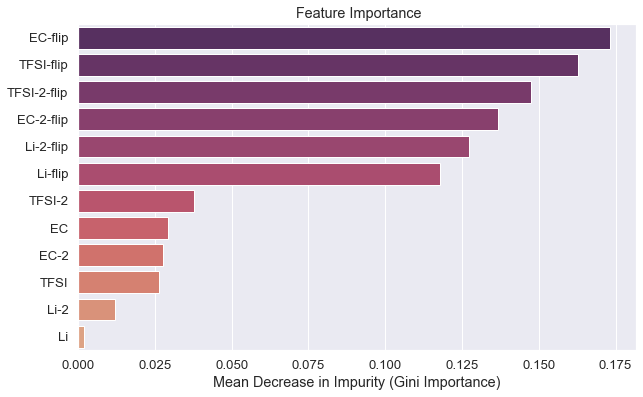

In [5]:
plot_impurity_feature_importance(best_model)

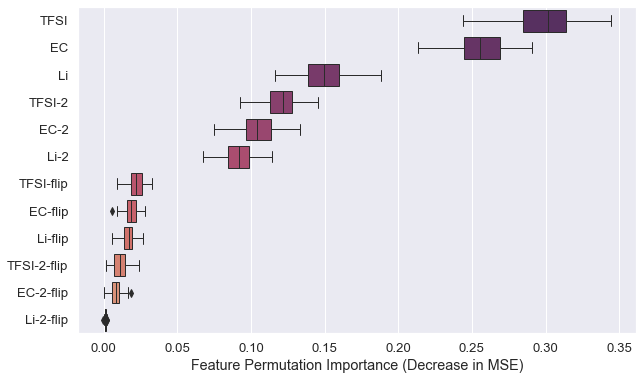

In [6]:
plot_permutation_importance(best_model, X_test, y_test)

In [4]:
explainer = shap.explainers.Tree(best_model['model'], X_train)
shap_values = explainer(X_train)

100%|===================| 19870/19920 [02:48<00:00]        

 98%|===================| 4892/4980 [00:41<00:00]        

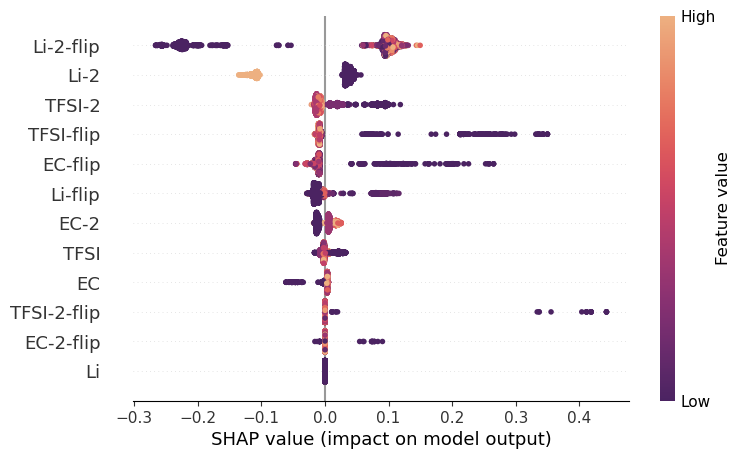

In [8]:
explainer = shap.explainers.Tree(best_model['model'], X_test)
shap_values = explainer(X_test)

plt.style.use('default')
shap.plots.beeswarm(shap_values, show=False, color=plt.get_cmap('flare_r'), max_display=12, plot_size=[8,5])
plt.gcf().axes[-1].set_aspect(25)
plt.gcf().axes[-1].set_box_aspect(25)
# plt.savefig(f"figures/shap_rfr_new.png", dpi=400, bbox_inches="tight")
plt.show()